In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import calendar
%matplotlib inline
from datetime import date, datetime
from sklearn import metrics
from sklearn import preprocessing 
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import r2_score
import warnings
from sklearn.ensemble import GradientBoostingRegressor

# Feature Engineering
    The changes I will make in order to make this data set more accessible are:
    1- I will read in the date column as type Date so that it can be used later in in time series forcasting 
    2- I will label encode the Warehouse column.
    3- Remove Product_ and Cetegory_ from the product code and product cetegory columns, and then convert their types to integers so they can be used in my model. To convert Demand to an int I had to first remove the () around negative numbers.
    4- Convert Order_Demand from object types to integer types by removing () from negative numbers
    5- Create a "Days" column to represent days passed since the first date in this data set. Since time move linearly, this will the points in my linear regression plot make sense.

In [2]:
#Drop values containing na, read in the date column as type date
productData = pd.read_csv('hpd.csv', parse_dates=[3])
productData = productData.dropna()
productData.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [3]:
#Remove Product_ and Category_ 
productData['Product_Code'] = productData['Product_Code'].str[8:]
productData['Product_Category'] = productData['Product_Category'].str[9:]

#then convert to int's
productData['Product_Code'] = productData['Product_Code'].astype(int)
productData['Product_Category'] = productData['Product_Category'].astype(int)

#Convert Order_Demand from object type to int
productData['Order_Demand'].replace('[(]', '-', inplace=True, regex=True)
productData['Order_Demand'].replace('[)]', '', inplace=True, regex=True)
productData['Order_Demand'] = productData['Order_Demand'].astype(int)

productData.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,993,Whse_J,28,2012-07-27,100
1,979,Whse_J,28,2012-01-19,500
2,979,Whse_J,28,2012-02-03,500
3,979,Whse_J,28,2012-02-09,500
4,979,Whse_J,28,2012-03-02,500


I am now going to label encode the Warehouse attribute, so that I can place warehouse values into a model.

In [4]:
#label encode in place
label_encoder = preprocessing.LabelEncoder() 
label_encoder.fit(productData['Warehouse'])
productData['Warehouse'] = label_encoder.transform(productData['Warehouse'])
productData.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,993,2,28,2012-07-27,100
1,979,2,28,2012-01-19,500
2,979,2,28,2012-02-03,500
3,979,2,28,2012-02-09,500
4,979,2,28,2012-03-02,500


Now, this assignment asked us to make predictions for demand for a particular product, I will chose product 993 arbitrarily, as it is the first product I see above. I will drop all other rows from this data set. (I will then check that product 993 has enough points to sample)

In [5]:
productData = productData[productData.Product_Code == 993]
productData.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,993,2,28,2012-07-27,100
34292,993,2,28,2012-09-13,300
34295,993,2,28,2012-09-19,500
34298,993,2,28,2012-10-09,300
85872,993,2,28,2012-11-08,200


I want to make sure that this product has at least 60 order demand values, one per month from each of the 5 years in this data set.

In [6]:
len(productData.index)

312

Since I have more than enough values to work with, I will proceed with product 993. 

# Creating Prediction Model

First I am going to check out the information relating to each column, then plot the demand for product 993 against date.

In [7]:
#Verify Date column is of type datetime64
productData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 1045085
Data columns (total 5 columns):
Product_Code        312 non-null int32
Warehouse           312 non-null int32
Product_Category    312 non-null int32
Date                312 non-null datetime64[ns]
Order_Demand        312 non-null int32
dtypes: datetime64[ns](1), int32(4)
memory usage: 9.8 KB


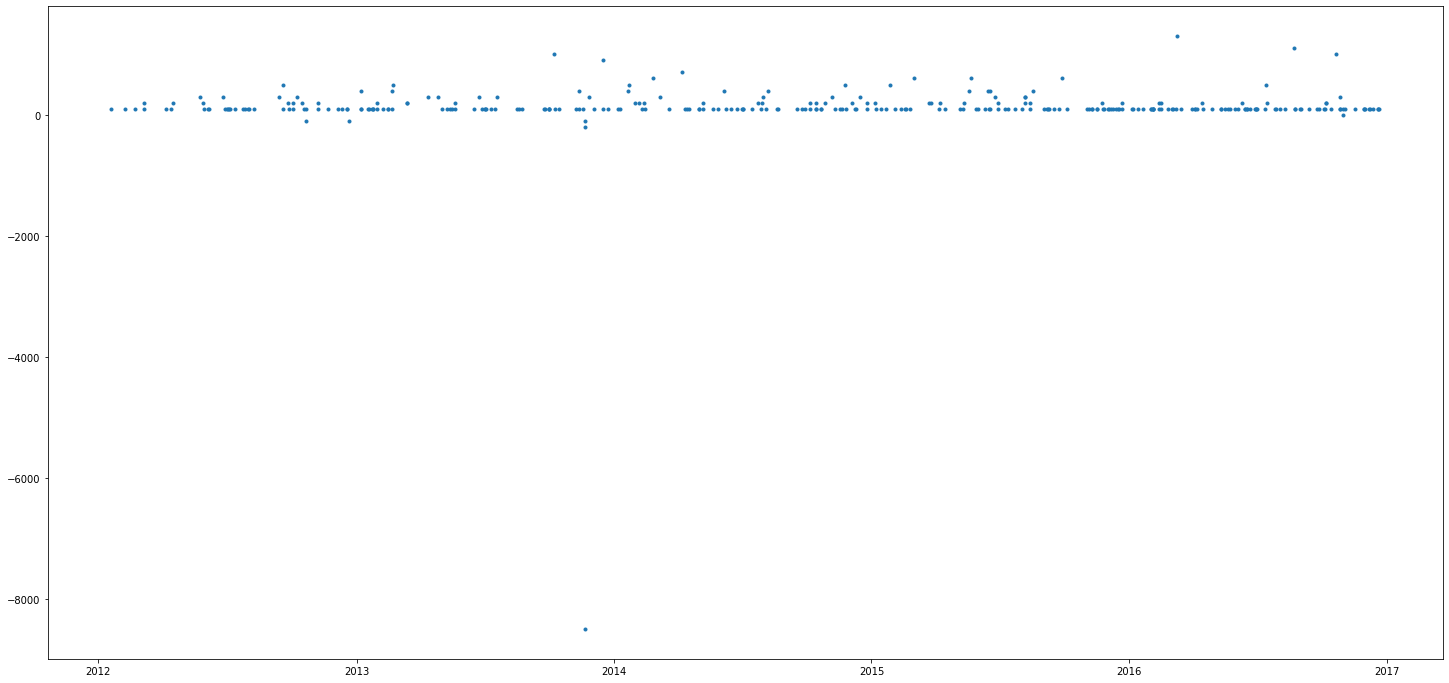

In [8]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize = (25,12))
plt.plot(productData['Date'], productData['Order_Demand'], ".")

I can see that I clearly have large negative outliars. This would likely be the result of someone returning inventory, or possibly a mistake in the data set. I am now going to remove negative values from my demand column to see if I can create a more clear picture of demand trends. It would not make sense to factor in returns when calculating how much inventory should be shipped out on a particular day.

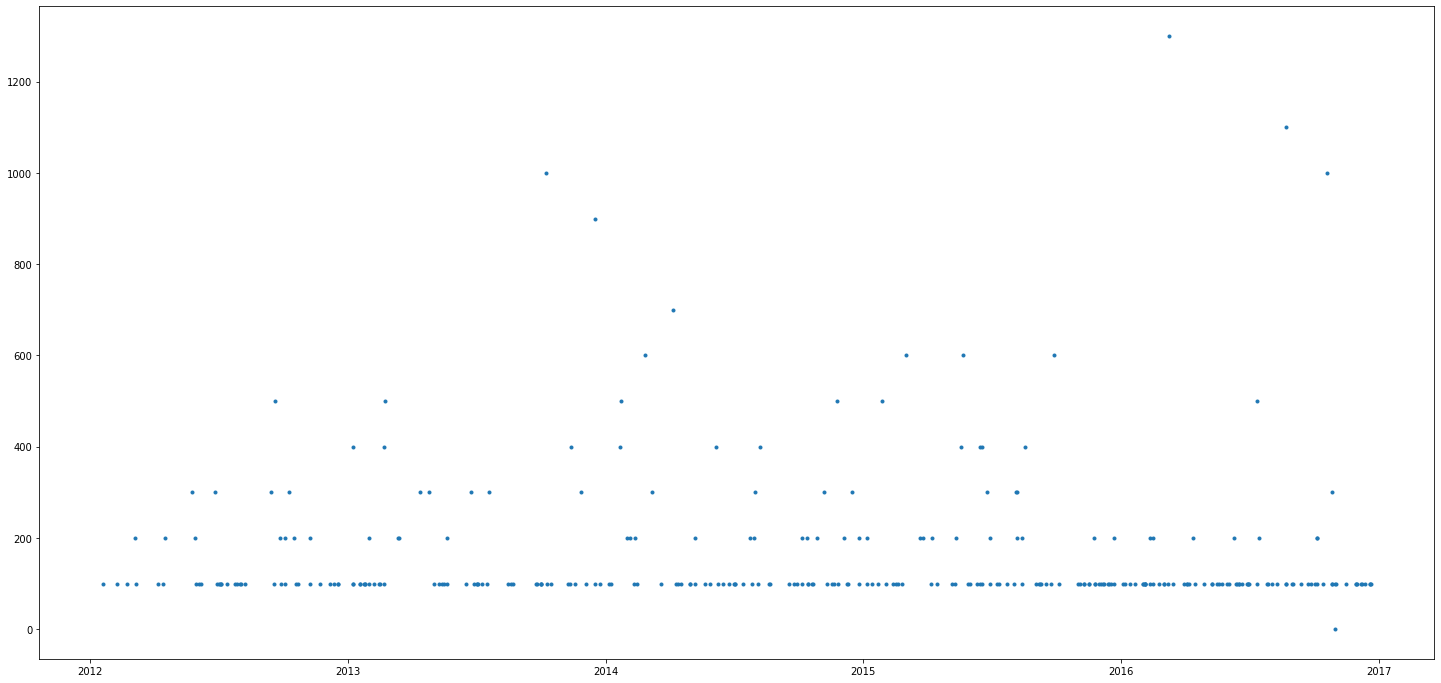

In [9]:
productData = productData[productData.Order_Demand >= 0]
plt.figure(figsize = (25,12))
plt.plot(productData['Date'], productData['Order_Demand'], ".")

I will now sort my chart by date, and create a new chart where I graph demand vs days since the start. This will allow me to train my regression model on the first 90% of values, then make predictions (test set) on the last 10% of values.

In [10]:
productData = productData.sort_values(by=['Date']).reset_index()
productData['Days'] = (productData['Date'] - productData['Date'][0])
productData['Days'] = productData['Days'].apply(lambda x : x.days)
productData.head()

,index,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Days
0,137808,993,2,28,2012-01-19,100,0
1,137812,993,2,28,2012-02-08,100,20
2,146258,993,2,28,2012-02-22,100,34
3,87561,993,2,28,2012-03-05,200,46
4,137817,993,2,28,2012-03-06,100,47


R^2 Coefficient:
-0.002347236025507904


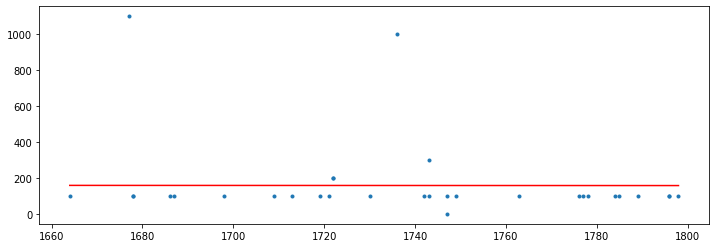

In [11]:
x = productData[['Days']]
y = productData['Order_Demand']
productData.head()

#split data into first 90% of data (dates) to train on, then test on last 10% of data
train_pct_index = int(0.9 * len(x))
X_train, X_test = x[:train_pct_index], x[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]



lm = LinearRegression()
lm = lm.fit( X_train, y_train )
y_predict = lm.predict(X_test)

predx = lm.score(X_test, y_test)
print("R^2 Coefficient:")
print(predx)
plt.figure(figsize = (12,4))
plt.plot(X_test, y_test, ".")

plt.plot(X_test, y_predict, "r")

Clearly this linear model was poor, as it's R^2 value was negative, meaning that guessing the average is a better predictor than using the model. I will now attempt to create a time series model out of this data.

In [12]:
ts = productData[['Date', 'Order_Demand']].copy()
ts.head()

,Date,Order_Demand
0,2012-01-19,100
1,2012-02-08,100
2,2012-02-22,100
3,2012-03-05,200
4,2012-03-06,100


In [13]:
ts.set_index('Date', inplace=True)
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 307 entries, 2012-01-19 to 2016-12-21
Data columns (total 1 columns):
Order_Demand    307 non-null int32
dtypes: int32(1)
memory usage: 3.6 KB


I am now using resample to replace all days with no data as 0's, since there was no order demand that day.

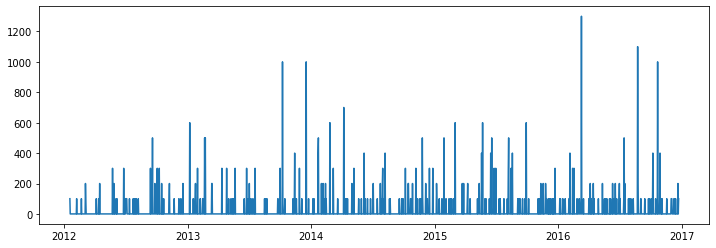

In [14]:
ts = ts.resample('D').sum()
plt.figure(figsize = (12,4))
plt.plot(ts)

Here I am plotting the original data vs the moving average. I have chosen a window of size 10 meaning each point is an average of the 10 days around it. As the window grows the jumps in the data become smaller, as the averages become closer together.

            Order_Demand
Date                    
2012-01-19           NaN
2012-01-20           NaN
2012-01-21           NaN
2012-01-22           NaN
2012-01-23           NaN
2012-01-24           NaN
2012-01-25           NaN
2012-01-26           NaN
2012-01-27           NaN
2012-01-28          10.0


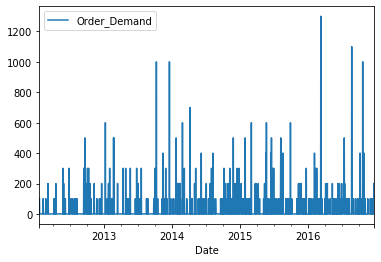

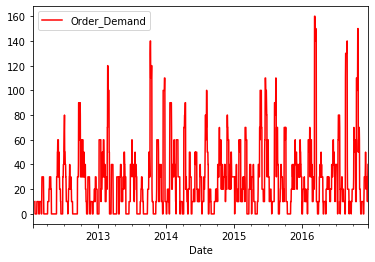

In [15]:
rolling = ts.rolling(window=10)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
ts.plot()
rolling_mean.plot(color='red')

In [16]:
rolling_mean

,Order_Demand
Date,
2012-01-19,NaN
2012-01-20,NaN
2012-01-21,NaN
2012-01-22,NaN
2012-01-23,NaN
2012-01-24,NaN
2012-01-25,NaN
2012-01-26,NaN
2012-01-27,NaN


I am going to add a "Days" column so I can run the same test I ran before again using my rolling mean with a 10 day window. Then I removed the first 10 values from rolling_mean data set so I have no NAN values. 

In [17]:
rolling_mean = rolling_mean.sort_values(by=['Date']).reset_index()
rolling_mean['Days'] = (rolling_mean['Date'] - rolling_mean['Date'][0])
rolling_mean['Days'] = rolling_mean['Days'].apply(lambda x : x.days)

rolling_mean = rolling_mean.iloc[9:]
rolling_mean.head()

,Date,Order_Demand,Days
9,2012-01-28,10.0,9
10,2012-01-29,0.0,10
11,2012-01-30,0.0,11
12,2012-01-31,0.0,12
13,2012-02-01,0.0,13


R^2 Coefficient:
-0.0025133234823146995


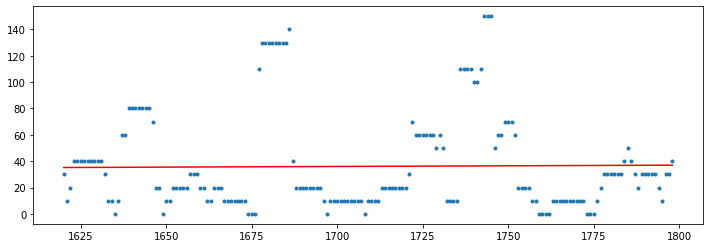

In [18]:
x = rolling_mean[['Days']]
y = rolling_mean['Order_Demand']

#split data into first 90% of data (dates) to train on, then test on last 10% of data
train_pct_index = int(0.9 * len(x))
X_train, X_test = x[:train_pct_index], x[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]



lm = LinearRegression()
lm = lm.fit( X_train, y_train )
y_predict = lm.predict(X_test)

predx = lm.score(X_test, y_test)
print("R^2 Coefficient:")
print(predx)
plt.figure(figsize = (12,4))
plt.plot(X_test, y_test, ".")

plt.plot(X_test, y_predict, "r")

Clearly linear regression models are not working for this data set. I have attempted this model for both the original data set and the same data set but calculated with a 10-day moving average. This makes sense because this data set is not linear, and has no clear trends. For this reason I will now attempt to plot the data using a gradient boosting regressor.

# Gradient boosting regressor

In [19]:
# Fit the training & test data, then print the R^2 values.
def fitAndPrint(reg):
        reg = reg.fit(X_train, y_train)
        print("-Testing R^2: %4.4f" %
          r2_score(y_test, reg.predict(X_test), multioutput='variance_weighted'))


In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    gb = GradientBoostingRegressor()
    print("Gradient Boosting Regressor:")
    fitAndPrint(gb)

Gradient Boosting Regressor:
-Testing R^2: -0.0059


I have now tested the data using both a linear and a gradient boosting regressor. Neither had much accuracy, likely due to the randomness of this data set. In both cases, it was more beneficial to just guess the average demand each day rather than try to calculate it use one of my 3 regression models (linear, linear on moving average, gradient boosting). It would have been easier to create a model if the demand had been consistent, or if orders were placed every day.